In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

In [3]:
train_X = pd.read_pickle('generated_files/train_X.pkl')
train_Y = pd.read_pickle('generated_files/train_Y.pkl')

test_X = pd.read_pickle('generated_files/test_X.pkl')
test_Y = pd.read_pickle('generated_files/test_Y.pkl')

In [4]:
def reduce_train(train_X, train_Y):
    is_changed_series = train_Y.sum(axis=1) > 0
    
    X_reduced = train_X[is_changed_series].reset_index(drop=True)
    Y_reduced = train_Y[is_changed_series].reset_index(drop=True)
    
    return X_reduced, Y_reduced

X_tr_reduced, Y_tr_reduced = reduce_train(train_X, train_Y)
X_ts_reduced, Y_ts_reduced = reduce_train(test_X, test_Y)

In [5]:
from src.metrics import mapk, transform_y

In [6]:
from sklearn.multiclass import OneVsRestClassifier
import xgboost

# Try Regular XGBoost

In [328]:
prediction_features = [col for col in train_X.columns if 'FT_' in col]

from sklearn.preprocessing import LabelBinarizer
prov_bin = LabelBinarizer().fit(X_nan_ts_reduced['Province_Name'][~X_nan_ts_reduced['Province_Name'].isna()])

def prepare_xgb_data(X, vectorize_province=False):
    xgb_X = X.drop(['Row_Date', 'Customer_Code'], axis=1)
    
    if not vectorize_province:
        xgb_X['Province_Name'] = xgb_X['Province_Name'].apply(lambda s: 1 if s == 'MADRID' else 0).astype('int64')
    else:
        provs_mat = prov_bin.transform(xgb_X['Province_Name'])
        for row, c in zip(provs_mat.T, prov_bin.classes_):
            xgb_X[c] = row
        xgb_X.drop('Province_Name', inplace=True, axis=1)
        
    xgb_X['Sex'] = xgb_X['Sex'].apply(lambda s: 1 if s == 'V' else 0).astype('int64')
    xgb_X['Segmentation'] = xgb_X['Segmentation'].apply(lambda s: 1 if 'TOP' in s else 0 if 'PARTICULARES' in s else -1).astype('int64')
    
#     context_features = [col for col in xgb_X.columns if 'FT_' not in col]
#     xgb_X = xgb_X[context_features]
    
    return xgb_X

In [323]:
model = OneVsRestClassifier(n_jobs=-1, estimator=xgboost.XGBClassifier())
model.fit(prepare_xgb_data(X_tr_reduced), X_tr_reduced[prediction_features] + Y_tr_reduced)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
                    n_jobs=-1)

In [324]:
try_y = model.predict(prepare_xgb_data(X_ts_reduced))

In [325]:
mapk(transform_y(Y_ts_reduced, thresh=0.01), transform_y(pd.DataFrame(try_y), thresh=0.01), k=7)

0.44690843732717783

In [326]:
def predict_row(y_row, x_row, n_labels, thresh):
    row = y_row * (~x_row.astype('bool'))
    res = np.argsort(-row)[:n_labels]
    res = res[row[res] >= thresh]
    return res

probas = model.predict_proba(prepare_xgb_data(X_ts_reduced))
try_y2 = [predict_row(y_row, x_row, 7, 0.0001) for y_row, x_row in zip(probas, X_ts_reduced[prediction_features].values)]

In [327]:
mapk(transform_y(Y_ts_reduced, thresh=0.01), try_y2, k=7)

0.7915140593494846

# Try reducing overfitting by discarding the label data for its prediction

In [251]:
def fit_model(train_X, train_Y):
    models = []

    xgb_X = prepare_xgb_data(train_X)

    for pred in prediction_features:
#         pred_train_X = xgb_X.drop(pred, axis=1)
        pred_train_X = xgb_X.copy()
        pred_train_X[pred] = 0
        
        pred_train_Y = xgb_X[pred] + train_Y[pred]

        model = xgboost.XGBClassifier(n_jobs=-1)
        model.fit(pred_train_X, pred_train_Y)

        models.append(model)
    
    return models

def predict_proba(models, X):
    per_pred_proba = []
    
    xgb_X = prepare_xgb_data(X)
    
    for pred, model in zip(prediction_features, models):
#         pred_test_X = xgb_X.drop(pred, axis=1)
        pred_test_X = xgb_X.copy()
        pred_test_X[pred] = 0
        
        res = model.predict_proba(pred_test_X)
        per_pred_proba.append(res)
    
    return np.array(per_pred_proba).T

In [252]:
models = fit_model(X_tr_reduced, Y_tr_reduced)

In [253]:
probas2 = predict_proba(models, X_ts_reduced)[1]
try_y3 = [predict_row(y_row, x_row, 7, 0.000001) for y_row, x_row in zip(probas2, X_ts_reduced[prediction_features].values)]

print("apparently, disacrding the previous label data performs worse:")
mapk(transform_y(Y_ts_reduced, thresh=0.01), try_y3, k=7)

apparently, disacrding the previous label data performs worse:


0.7741923173366584

# Feature Importance

Text(0.5, 1, 'Feature Importances Found By XGBoost')

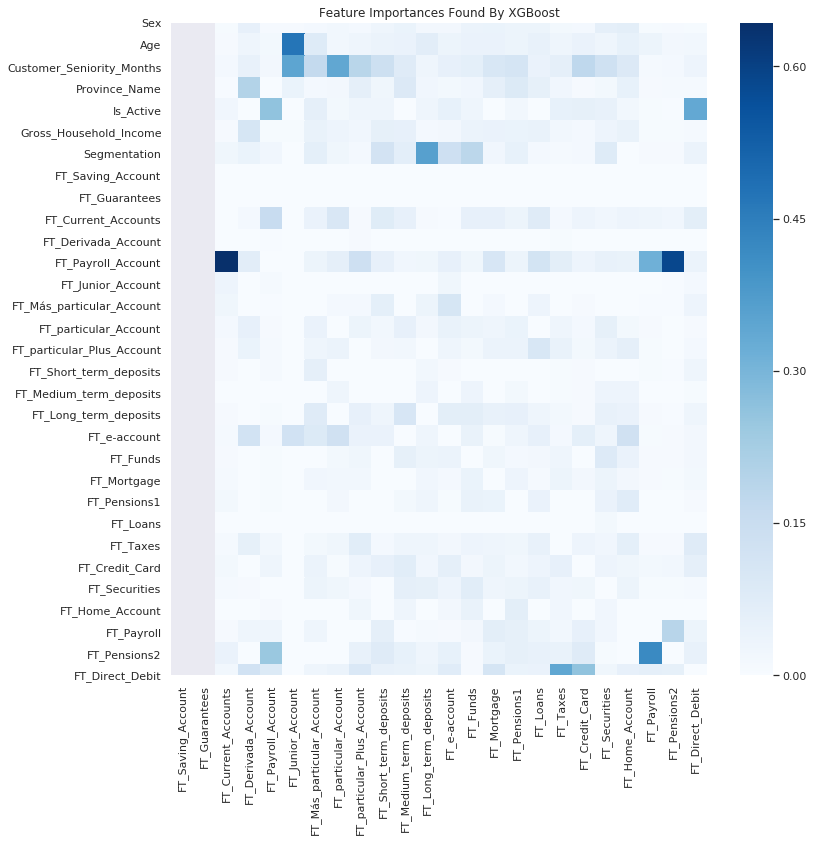

In [82]:
fts = prepare_xgb_data(X_tr_reduced).columns
feature_importances = pd.DataFrame(np.array([est.feature_importances_ for est in models]), columns=fts, index=prediction_features)

sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(feature_importances.T, cmap='Blues').set_title('Feature Importances Found By XGBoost')

# Check effect of train size on performance

In [56]:
def fit_pointwise_model(train_X, train_Y):
    model = OneVsRestClassifier(xgboost.XGBClassifier())
    model.fit(prepare_xgb_data(train_X), train_X[prediction_features] + train_Y)
    return model

def predict_pointwise_ordering(model, X):
    probas = model.predict_proba(prepare_xgb_data(X))
    res = [predict_row(y_row, x_row, 7, 0.0001) for y_row, x_row in zip(probas, X[prediction_features].values)]
    return res

def evaluate_predictions(Y, ordering):
    return mapk(transform_y(Y, thresh=0.01), ordering, k=7)

data_sizes = np.arange(1000, len(X_tr_reduced), 1000)
train_accuracies = []
test_accuracies = []

for data_size in data_sizes:
    print(data_size)
    
    X, Y = X_tr_reduced[:data_size], Y_tr_reduced[:data_size]
    
    model = fit_pointwise_model(X, Y)
    
    train_ordering = predict_pointwise_ordering(model, X)
    train_mapk = evaluate_predictions(Y, train_ordering)
    
    test_ordering = predict_pointwise_ordering(model, X_ts_reduced)
    test_mapk = evaluate_predictions(Y_ts_reduced, test_ordering)
    
    train_accuracies.append(train_mapk)
    test_accuracies.append(test_mapk)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [62]:
test_accuracies

[0.6758378478708803,
 0.7541829312696007,
 0.7542913881270606,
 0.7677092843918206,
 0.7689798040690705,
 0.7684448497714025,
 0.7782892540266485,
 0.785332393867884,
 0.7860758081635597,
 0.785712731388451,
 0.7884016463831439,
 0.7883182537965052,
 0.7918171099500898,
 0.7911540740511742]

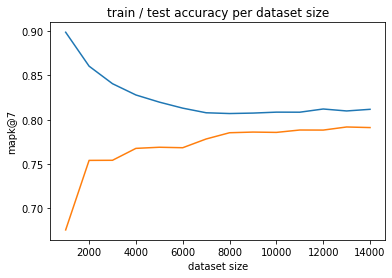

In [61]:
plt.title("train / test accuracy per dataset size")
plt.xlabel("dataset size")
plt.ylabel("mapk@7")
plt.plot(data_sizes, train_accuracies)
plt.plot(data_sizes, test_accuracies)

# Try RandomForestClassifier, LogisticRegression

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
model.fit(prepare_xgb_data(X_tr_reduced), X_tr_reduced[prediction_features] + Y_tr_reduced)

probas = model.predict_proba(prepare_xgb_data(X_ts_reduced))
try_y = [predict_row(y_row, x_row, 7, 0.0001) for y_row, x_row in zip(probas, X_ts_reduced[prediction_features].values)]
mapk(transform_y(Y_ts_reduced, thresh=0.01), try_y, k=7)

0.7639388309605022

In [109]:
model = OneVsRestClassifier(LogisticRegression())
model.fit(prepare_xgb_data(X_tr_reduced), X_tr_reduced[prediction_features] + Y_tr_reduced)

probas = model.predict_proba(prepare_xgb_data(X_ts_reduced))
try_y = [predict_row(y_row, x_row, 7, 0.0001) for y_row, x_row in zip(probas, X_ts_reduced[prediction_features].values)]
mapk(transform_y(Y_ts_reduced, thresh=0.01), try_y, k=7)

0.6468274148727514

# Try to play with XGBoost Parameters

In [264]:
data_size = 14200
X, Y = X_tr_reduced[:data_size], Y_tr_reduced[:data_size]

model = OneVsRestClassifier(n_jobs=-1, estimator=xgboost.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100, tree_method='hist', gamma=0, reg_lambda=1, subsample=1, colsample_bytree=1))
model.fit(prepare_xgb_data(X), X[prediction_features] + Y)

probas = model.predict_proba(prepare_xgb_data(X_ts_reduced))
try_y = [predict_row(y_row, x_row, 7, 0.0001) for y_row, x_row in zip(probas, X_ts_reduced[prediction_features].values)]
mapk(transform_y(Y_ts_reduced, thresh=0.01), try_y, k=7)

0.7906303263569007

# Try to keep nans

In [330]:
from src.clean_dataset import clean_dataset

train_dataset = pd.read_pickle('generated_files/train.pkl')
train_X_nan,train_Y_nan = clean_dataset(train_dataset, fill_na_context_features=False)

test_dataset = pd.read_pickle('generated_files/test.pkl')
test_X_nan,test_Y_nan = clean_dataset(test_dataset, fill_na_context_features=False)

train_Y_nan, test_Y_nan = train_Y_nan.fillna(0), test_Y_nan.fillna(0)

X_nan_tr_reduced, Y_nan_tr_reduced = reduce_train(train_X_nan, train_Y_nan)
X_nan_ts_reduced, Y_nan_ts_reduced = reduce_train(test_X_nan, test_Y_nan)

In [331]:
def prepare_xgb_data_nan(X):
    xgb_X = X.drop(['Row_Date', 'Customer_Code'], axis=1)
    xgb_X['Province_Name'] = xgb_X['Province_Name'].apply(lambda s: 1 if s == 'MADRID' else 0).astype('float64')
    xgb_X['Sex'] = xgb_X['Sex'].apply(lambda s: 1 if s == 'V' else 0).astype('float64')
    xgb_X['Segmentation'] = xgb_X['Segmentation'].apply(lambda s: 1 if 'TOP' in s else 0 if 'PARTICULARES' in s else -1).astype('float64')
    
    return xgb_X

In [333]:
model = OneVsRestClassifier(n_jobs=-1, estimator=xgboost.XGBClassifier(tree_method='hist'))
model.fit(prepare_xgb_data_nan(X_nan_tr_reduced), X_nan_tr_reduced[prediction_features].fillna(0) + Y_nan_tr_reduced)

probas = model.predict_proba(prepare_xgb_data_nan(X_nan_ts_reduced))
try_y = [predict_row(y_row, x_row, 7, 0.0001) for y_row, x_row in zip(probas, X_nan_ts_reduced[prediction_features].fillna(0).values)]
mapk(transform_y(Y_nan_ts_reduced, thresh=0.01), try_y, k=7)

0.7910407284893326